# Setup

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import shutil

import torch, torchvision, torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

from keras.utils import image_dataset_from_directory

import os
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image

from torchvision import datasets, transforms


# Define Paths

In [3]:
# Defining paths

TRAIN_DATA_DIR = os.path.join("data/train")
VAL_DATA_DIR = os.path.join("data/val")

CLEAN_TRAIN_DATA_DIR = os.path.join("clean/train")
CLEAN_VAL_DATA_DIR = os.path.join("clean/val")

OUTPUT_BASE = "data_augmented"
os.makedirs(OUTPUT_BASE, exist_ok=True)

In [ ]:
sizes = [120, 150, 200]
strengths = ["moderate", "strong", "grayscale"]

# --- AUGMENTATION PIPELINES ---
def get_augmentations(size, strength="moderate", grayscale=False):
    """Return augmentation transform for saving images."""

    augment_list = [
        transforms.Resize((size, size)),
        transforms.RandomRotation(10 if strength=="moderate" else 25),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.1) if strength=="moderate" else (0.15, 0.2),
            shear=5 if strength=="moderate" else 15,
            scale=(0.9, 1.1) if strength=="moderate" else (0.8, 1.2)
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ColorJitter(
            brightness=0.2 if strength=="moderate" else 0.4,
            contrast=0.2 if strength=="moderate" else 0.4
        ),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.2 if strength=="moderate" else 0.4,
            scale=(0.02, 0.1) if strength=="moderate" else (0.05, 0.2),
            ratio=(0.3, 3.3)
        )
    ]
    if grayscale:
        augment_list.insert(-2, transforms.Grayscale(num_output_channels=3))

    return transforms.Compose(augment_list)


# --- GENERATE AND SAVE AUGMENTED DATASETS ---
def create_augmented_dataset(size, strength, grayscale=False):
    """Creates and saves augmented dataset for one configuration."""
    tag = f"{strength}_{size}"
    if grayscale and "gray" not in tag:
        tag = f"grayscale_{strength}_{size}"

    print(f"\n🔧 Generating dataset: {tag}")

    out_dir = os.path.join(OUTPUT_BASE, tag)
    os.makedirs(out_dir, exist_ok=True)

    transform = get_augmentations(size, strength, grayscale)
    base_dataset = datasets.ImageFolder(TRAIN_DATA_DIR)

    for class_idx, class_name in enumerate(base_dataset.classes):
        class_input_dir = os.path.join(TRAIN_DATA_DIR, class_name)
        class_output_dir = os.path.join(out_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        image_files = os.listdir(class_input_dir)
        for img_file in tqdm(image_files, desc=f"{class_name} ({tag})"):
            img_path = os.path.join(class_input_dir, img_file)

            # Load and apply augmentation
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                aug_img = transform(img)

            # Save augmented image
            base_name = os.path.splitext(img_file)[0]
            save_path = os.path.join(class_output_dir, f"{base_name}_aug.png")
            save_image(aug_img, save_path)


# --- MAIN LOOP ---
for size in sizes:
    create_augmented_dataset(size, strength="moderate", grayscale=False)
    create_augmented_dataset(size, strength="strong", grayscale=False)
    create_augmented_dataset(size, strength="moderate", grayscale=True)
    create_augmented_dataset(size, strength="strong", grayscale=True)
create_augmented_dataset(170, strength="moderate", grayscale=False)# 170 as most images have height around 170. Medium RGB bc that performed best
print("\n✅ All augmented datasets generated and saved!")



✅ All augmented datasets generated and saved!


# Reading data

## Read each augmentation setup separatly

# Do everything

In [17]:
# --- CONFIG ---
BATCH_SIZE = 32
EPOCHS = 200
NUM_CLASSES = 10
DATA_AUG_DIR = OUTPUT_BASE

# --- Prepare results storage ---
results = []

# --- Loop through each augmented folder ---
for folder_name in os.listdir(DATA_AUG_DIR):
    folder_path = os.path.join(DATA_AUG_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n=== Processing folder: {folder_name} ===")

    # Determine image size from folder name (assumes _<size> in folder, e.g., moderate_150)
    size_tokens = folder_name.split("_")
    input_size = int(size_tokens[-1])  # last token should be the image size
    img_height = img_width = input_size

    # --- Load training dataset ---
    train_ds = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # --- Resize validation dataset to match training ---
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DATA_DIR,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # --- Define CNN model ---
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CLASSES)
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # --- Callbacks ---
    checkpoint_path = os.path.join(folder_path, f"best_model_{folder_name}.keras")
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1
    )

    earlystop_cb = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # --- Train ---
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_cb, earlystop_cb],
        verbose=2
    )

    # --- Store best validation accuracy ---
    best_val_loss = max(history.history['val_loss'])
    results.append({"folder": folder_name, "best_val_loss": best_val_loss, "model_path": checkpoint_path})

# --- Display results as a table ---
results_df = pd.DataFrame(results)
print("\n=== Best Validation Accuracy per Dataset ===")
print(results_df)


=== Processing folder: grayscale_moderate_120 ===
Found 2300 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.
Epoch 1/200

Epoch 1: val_loss improved from inf to 2.30154, saving model to data_augmented\grayscale_moderate_120\best_model_grayscale_moderate_120.keras
72/72 - 5s - 66ms/step - accuracy: 0.1061 - loss: 2.3045 - val_accuracy: 0.1005 - val_loss: 2.3015
Epoch 2/200

Epoch 2: val_loss improved from 2.30154 to 2.30110, saving model to data_augmented\grayscale_moderate_120\best_model_grayscale_moderate_120.keras
72/72 - 1s - 16ms/step - accuracy: 0.1083 - loss: 2.3015 - val_accuracy: 0.1044 - val_loss: 2.3011
Epoch 3/200

Epoch 3: val_loss did not improve from 2.30110
72/72 - 1s - 15ms/step - accuracy: 0.1178 - loss: 2.2994 - val_accuracy: 0.1034 - val_loss: 2.3023
Epoch 4/200

Epoch 4: val_loss did not improve from 2.30110
72/72 - 1s - 13ms/step - accuracy: 0.1087 - loss: 2.2911 - val_accuracy: 0.1083 - val_loss: 2.3182
Epoch 5/200

Epoch 5: val_loss did 

In [18]:
# --- Display results as a table ---
results_df = pd.DataFrame(results)
print("\n=== Best Validation Accuracy per Dataset ===")
print(results_df)


=== Best Validation Accuracy per Dataset ===
                    folder  best_val_loss  \
0   grayscale_moderate_120       3.698971   
1   grayscale_moderate_150       6.619439   
2   grayscale_moderate_200       2.289016   
3     grayscale_strong_120       2.390815   
4     grayscale_strong_150       2.355510   
5     grayscale_strong_200       2.442297   
6             moderate_120       2.298787   
7             moderate_150       2.149871   
8             moderate_200       2.263971   
9               strong_120       2.301927   
10              strong_150       2.292494   
11              strong_200       2.291467   

                                           model_path  
0   data_augmented\grayscale_moderate_120\best_mod...  
1   data_augmented\grayscale_moderate_150\best_mod...  
2   data_augmented\grayscale_moderate_200\best_mod...  
3   data_augmented\grayscale_strong_120\best_model...  
4   data_augmented\grayscale_strong_150\best_model...  
5   data_augmented\grayscale_str

In [28]:
# Load model (adjust path as needed)
model = tf.keras.models.load_model("data_augmented/grayscale_moderate_120/best_model_grayscale_moderate_120.keras")

# Print model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 5)    │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,272 (24.50 KB)

 Trainable params: 2,090 (8.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,182 (16.34 KB)

# Combined Dataset

In [4]:
# --- CONFIG ---
BATCH_SIZE = 32
EPOCHS = 200
NUM_CLASSES = 10
DATA_AUG_DIR = OUTPUT_BASE   # your augmented datasets root folder


# --- Prepare results storage ---
results = []

# --- Loop through each augmented folder ---
for folder_name in os.listdir(DATA_AUG_DIR):
    folder_path = os.path.join(DATA_AUG_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n=== Processing folder: {folder_name} ===")

    # Determine image size from folder name (assumes _<size> in folder name, e.g., moderate_150)
    size_tokens = folder_name.split("_")
    input_size = int(size_tokens[-1])  # last token is image size (e.g. 150)
    img_height = img_width = input_size

    # --- Load training dataset ---
    train_ds = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # --- Load validation dataset with matching size ---
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DATA_DIR,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # --- Define CNN model ---
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(5, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CLASSES)
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # --- Callbacks ---
    checkpoint_path = os.path.join(folder_path, f"best_model_{folder_name}.keras")
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1
    )

    earlystop_cb = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # --- Train ---
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_cb, earlystop_cb],
        verbose=2
    )

    # --- Collect metrics ---
    best_val_acc = max(history.history["val_accuracy"])
    best_val_loss = min(history.history["val_loss"])
    best_train_acc = max(history.history["accuracy"])
    total_params = model.count_params()

    # --- Store results ---
    results.append({
        "Folder": folder_name,
        "Best_Val_Acc": best_val_acc,
        "Best_Val_Loss": best_val_loss,
        "Best_Train_Acc": best_train_acc,
        "Total_Params": total_params,
        "Best_Model_Path": checkpoint_path
    })

# --- Display results as a table ---
results_df = pd.DataFrame(results)
print("\n=== Training Results Summary ===")
print(results_df)

# --- Save results to CSV ---
results_csv_path = os.path.join(DATA_AUG_DIR, "training_results_summary.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"\n✅ Results saved to: {results_csv_path}")



=== Processing folder: grayscale_moderate_120 ===
Found 2300 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.
Epoch 1/200

Epoch 1: val_loss improved from inf to 2.29850, saving model to data_augmented\grayscale_moderate_120\best_model_grayscale_moderate_120.keras
72/72 - 6s - 77ms/step - accuracy: 0.0887 - loss: 2.3127 - val_accuracy: 0.1180 - val_loss: 2.2985
Epoch 2/200

Epoch 2: val_loss improved from 2.29850 to 2.29716, saving model to data_augmented\grayscale_moderate_120\best_model_grayscale_moderate_120.keras
72/72 - 1s - 18ms/step - accuracy: 0.1226 - loss: 2.3001 - val_accuracy: 0.1327 - val_loss: 2.2972
Epoch 3/200

Epoch 3: val_loss improved from 2.29716 to 2.28594, saving model to data_augmented\grayscale_moderate_120\best_model_grayscale_moderate_120.keras
72/72 - 1s - 16ms/step - accuracy: 0.1265 - loss: 2.2905 - val_accuracy: 0.1415 - val_loss: 2.2859
Epoch 4/200

Epoch 4: val_loss improved from 2.28594 to 2.25353, saving model to data_augmented

KeyboardInterrupt: 

## Train on data in Strong_150 and Moderate_150

In [5]:
# --- Folder names to combine ---
COMBINE_FOLDERS = ["Strong_150", "Moderate_150"]

# --- Extract image size from folder name (assuming same size) ---


input_size = int(COMBINE_FOLDERS[0].split("_")[-1])
img_height = img_width = input_size

# --- Load and combine datasets ---
combined_train_ds = None

for folder_name in COMBINE_FOLDERS:
    folder_path = os.path.join(DATA_AUG_DIR, folder_name)
    print(f"Loading dataset: {folder_name}")
    
    ds = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    if combined_train_ds is None:
        combined_train_ds = ds
    else:
        combined_train_ds = combined_train_ds.concatenate(ds)

# Shuffle combined dataset for good measure
combined_train_ds = combined_train_ds.shuffle(buffer_size=1000)

# --- Validation dataset ---
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DATA_DIR,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- Define CNN model ---
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(5, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(5, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(5, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(5, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_CLASSES)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint_path = os.path.join(DATA_AUG_DIR, "best_model_combined_150.keras")
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# --- Train ---
history = model.fit(
    combined_train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=2
)

# --- Collect metrics ---
best_val_acc = max(history.history["val_accuracy"])
best_val_loss = min(history.history["val_loss"])
best_train_acc = max(history.history["accuracy"])
total_params = model.count_params()

# --- Save summary ---
results = {
    "Combination": "Strong_150 + Moderate_150",
    "Best_Val_Acc": best_val_acc,
    "Best_Val_Loss": best_val_loss,
    "Best_Train_Acc": best_train_acc,
    "Total_Params": total_params,
    "Best_Model_Path": checkpoint_path
}

results_df = pd.DataFrame([results])
print("\n=== Combined Training Results ===")
print(results_df)

results_csv_path = os.path.join(DATA_AUG_DIR, "combined_training_results.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"\n✅ Results saved to: {results_csv_path}")

Loading dataset: Strong_150
Found 2300 files belonging to 10 classes.
Loading dataset: Moderate_150
Found 2300 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.
Epoch 1/200

Epoch 1: val_loss improved from inf to 2.18169, saving model to data_augmented\best_model_combined_150.keras
144/144 - 9s - 61ms/step - accuracy: 0.1239 - loss: 2.2902 - val_accuracy: 0.1795 - val_loss: 2.1817
Epoch 2/200

Epoch 2: val_loss improved from 2.18169 to 1.92528, saving model to data_augmented\best_model_combined_150.keras
144/144 - 3s - 20ms/step - accuracy: 0.2037 - loss: 2.0113 - val_accuracy: 0.2341 - val_loss: 1.9253
Epoch 3/200

Epoch 3: val_loss improved from 1.92528 to 1.89623, saving model to data_augmented\best_model_combined_150.keras
144/144 - 3s - 19ms/step - accuracy: 0.2404 - loss: 1.9123 - val_accuracy: 0.2283 - val_loss: 1.8962
Epoch 4/200

Epoch 4: val_loss improved from 1.89623 to 1.87673, saving model to data_augmented\best_model_combined_150.keras
144/144 - 3s 

In [6]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 5)    │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 5)      │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 245)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,872 (38.57 KB)

 Trainable params: 3,290 (12.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,582 (25.71 KB)

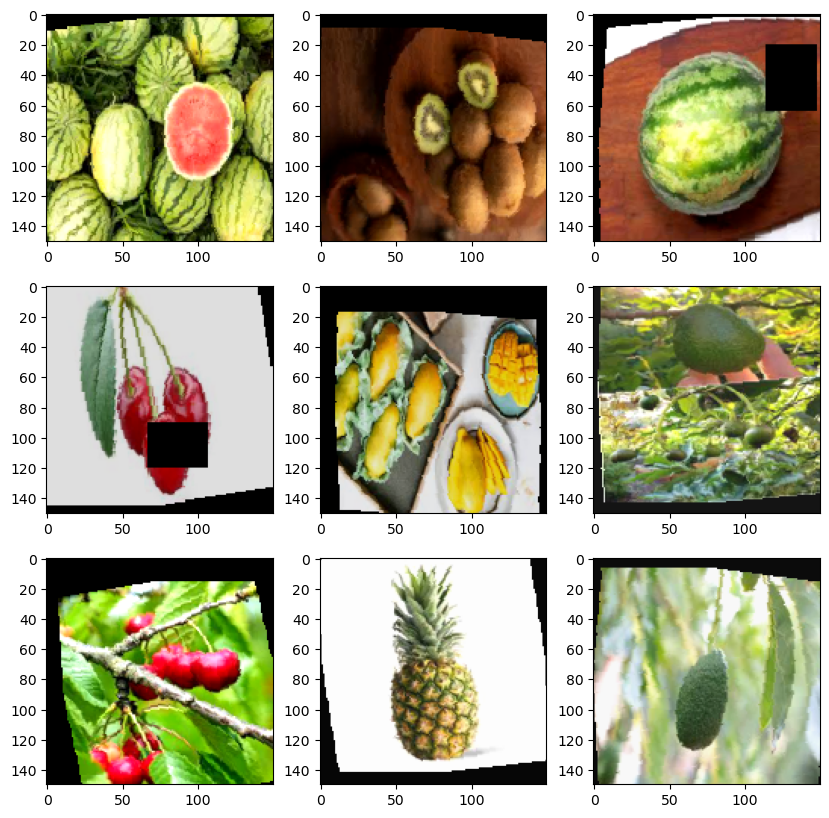

In [8]:
# plot image of combined dataset
plt.figure(figsize=(10, 10))
for images, labels in combined_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        